# Analyzing The Relationship Between Different Parts of the US and Fast-Food Preferences

## Introduction

This project seeks to answer the question of what is relationship between different areas of the U.S. and their fast food preferences. The data for the project comes from the following website: https://www.kaggle.com/datasets/datafiniti/fast-food-restaurants?select=Datafiniti_Fast_Food_Restaurants.csv and it is sourced from the datafiniti database. 

We found that while the different regions of the U.S. tended to follow the trend of the country as a whole when it came to fast food preferences, different regions did have different preferences, seen in how they differed from the trends shown for the country as a whole. 

The Y variable used to measure preferences was the number of fast food locations for different chains. This variable was readily available from the dataset and provided a reasonably accurate measure for measuring preferences between regions. The X varriables chosen to analyze the dataset were latitude, longitude, city, state, and BEA region, BEA regions being groupings of states used by the U.S. BEA to analyze economic trends. These location variables were chosen because they do a good job of representing areas of the U.S. at different scopes.

## Data Cleaning/Loading

Uncomment the 2 lines below if you do not yet have nbconvert or pyppeteer installed.

In [1]:
#pip install -q nbconvert

In [2]:
#pip install -q pyppeteer

In [3]:
import random
import numpy as np
import pandas as pd
import qeds
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
#Read all the Kaggle csv files to dataframes
dataAP18JN18 = pd.read_csv("..\Data\Datafiniti_Fast_Food_Restaurants.csv")
dataDE18MA19 = pd.read_csv("..\Data\Datafiniti_Fast_Food_Restaurants_May19.csv")
dataExtra = pd.read_csv("..\Data\FastFoodRestaurants.csv")

#Combine the two relevant DataFrames
fastFoodData = pd.concat([dataAP18JN18, dataDE18MA19], axis=0)

#Remove duplicates to clean up
fastFoodData = fastFoodData.drop_duplicates(subset=["address","name","latitude","longitude"],keep="last")

#Make sure all restaurant names are the same case, avoids variations in names
def makeUpper(name):
    return name.upper()

fastFoodData["name"] = fastFoodData["name"].astype(str).apply(makeUpper)

#Categorize all restaurants by BEA region
fastFoodData["BEA Region"] = fastFoodData["province"].astype(str)

def getBEARegion(state):
    if state in ["WA","OR","NV","CA","AK","HI"]:
        return "Far West"
    elif state in ["MT","ID","WY","UT","CO"]:
        return "Rocky Mountain"
    elif state in ["AZ","NM","OK","TX"]:
        return "Southwest"
    elif state in ["ND","SD","NE","KS","MN","IA","MO"]:
        return "Plains"
    elif state in ["WI","MI","IL","IN","OH"]:
        return "Great Lakes"
    elif state in ["VT","NH","ME","MA","RI","CT"]:
        return "New England"
    elif state in ["NY","NJ","PA","MD","DE","DC"]:
        return "Mideast"
    else:
        return "Southeast"

fastFoodData["BEA Region"] = fastFoodData["BEA Region"].apply(getBEARegion)

#Rename province to the more U.S. appropriate state
fastFoodData = fastFoodData.rename(columns={"province" : "state"})

## Summary Statistics Tables

In [5]:
dataForTable = fastFoodData[["BEA Region","city","state","name"]]
dataForTable = dataForTable.groupby(["BEA Region","state","city"])["name"].describe()
dataForTable

count unique              top freq
BEA Region state city                                          
Far West   AK    Anchorage      33     17           SUBWAY   14
                 Eagle River     1      1        CARL'S JR    1
                 Eielson Afb     1      1      BURGER KING    1
                 Fairbanks      13     10        AK BUFFET    2
                 Homer           1      1   COSMIC KITCHEN    1
...                            ...    ...              ...  ...
Southwest  TX    Wilmer          1      1   SONIC DRIVE IN    1
                 Winnsboro       1      1           SUBWAY    1
                 Woodville       2      2       MCDONALD'S    1
                 Woodway         1      1  JACK IN THE BOX    1
                 Wylie           3      3        TACO BELL    1

[4872 rows x 4 columns]

By breaking the restaurant data into increasingly more focused groups, going from the BEA region the restaurant falls in, all the way down to the city level, it allows us to analyze trends in fast food preferences at different scopes. For example, we can see the city of Riverton, WY, in the rocky mountain region has a strong taste for Pizza Hut. The city only has two fast food restaurants, and both of them are Pizza Hut.

In [6]:
latLonChain = fastFoodData[["latitude","longitude","name"]].groupby("name")
latLonChain.describe().sort_values(by=("latitude","count"),ascending=False)

latitude                                  \
                                      count       mean       std        min   
name                                                                          
MCDONALD'S                           2494.0  37.259811  5.406798  19.639560   
SUBWAY                               2030.0  38.132538  5.425891  20.752400   
TACO BELL                            1455.0  37.398850  5.164989  21.301100   
BURGER KING                          1209.0  37.704098  5.154968  19.504168   
WENDY'S                               824.0  37.256705  4.911577  20.890568   
...                                     ...        ...       ...        ...   
GEORGE'S CONEY'S GYRO'S                 1.0  39.879460       NaN  39.879460   
GEORGE'S BURGERS                        1.0  34.048100       NaN  34.048100   
GENTILE'S BAKERY - DELI - CATERING      1.0  41.408960       NaN  41.408960   
GENJI GO                                1.0  39.982200       NaN  39.982200   
ZZA PIZZA + SALAD                       1.0  38.649660       NaN  38.649660   

                                                                     \
                                          25%        50%        75%   
name                                                                  
MCDONALD'S                          33.656266  37.826752  41.288469   
SUBWAY                              34.508066  38.919074  41.503622   
TACO BELL                           33.856400  37.925744  40.801345   
BURGER KING                         34.024705  38.725060  41.512497   
WENDY'S                             33.842986  38.331296  40.800783   
...                                       ...        ...        ...   
GEORGE'S CONEY'S GYRO'S             39.879460  39.879460  39.879460   
GEORGE'S BURGERS                    34.048100  34.048100  34.048100   
GENTILE'S BAKERY - DELI - CATERING  41.408960  41.408960  41.408960   
GENJI GO                            39.982200  39.982200  39.982200   
ZZA PIZZA + SALAD                   38.649660  38.649660  38.649660   

                                              longitude              \
                                          max     count        mean   
name                                                                  
MCDONALD'S                          61.229535    2494.0  -92.317612   
SUBWAY                              64.856880    2030.0  -92.140655   
TACO BELL                           64.835505    1455.0  -94.255696   
BURGER KING                         64.673520    1209.0  -92.229156   
WENDY'S                             61.582250     824.0  -89.321363   
...                                       ...       ...         ...   
GEORGE'S CONEY'S GYRO'S             39.879460       1.0  -83.066650   
GEORGE'S BURGERS                    34.048100       1.0 -117.304000   
GENTILE'S BAKERY - DELI - CATERING  41.408960       1.0  -81.692880   
GENJI GO                            39.982200       1.0  -82.818600   
ZZA PIZZA + SALAD                   38.649660       1.0  -90.300200   

                                                                       \
                                          std         min         25%   
name                                                                    
MCDONALD'S                          16.012004 -159.368680  -97.483929   
SUBWAY                              16.106057 -157.875950  -97.349212   
TACO BELL                           15.779966 -159.378127 -105.256744   
BURGER KING                         15.935281 -158.078537  -98.221865   
WENDY'S                             13.703227 -156.461865  -94.687217   
...                                       ...         ...         ...   
GEORGE'S CONEY'S GYRO'S                   NaN  -83.066650  -83.066650   
GEORGE'S BURGERS                          NaN -117.304000 -117.304000   
GENTILE'S BAKERY - DELI - CATERING        NaN  -81.692880  -81.692880   
GENJI GO                                  NaN  -82.818600  -82

Another useful summary statistic table brings in latitude and longitude as possible independent variables. Although the table is grouped by restaurant, it still provides valuable information about how each chain is spread across the U.S., such as the average location of a restaurant for a brand. For example, when it comes to the 5 restaurants with the most locations in the U.S., we can see how similarly distributed they are to one another. This tells us that although certain areas may prefer certain brands disproportionately compared to the rest of the country, the largest fast-food chains tend to be concentrated around the same places.

## Plots, Histograms, Figures

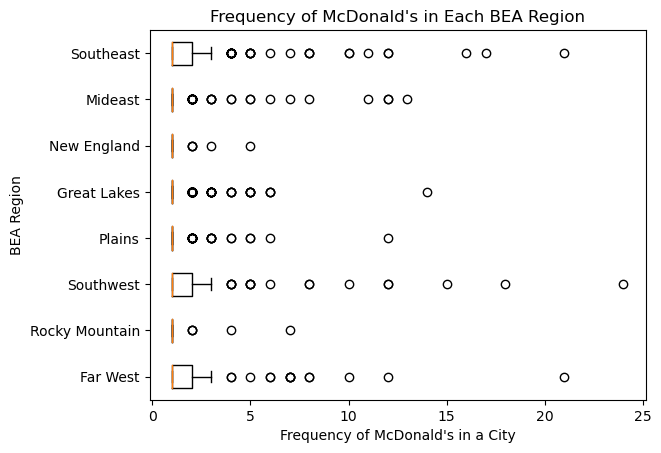

In [7]:
McDIsolated = fastFoodData.groupby("name").get_group("MCDONALD'S")
McDBoxData = McDIsolated.groupby(["BEA Region","city"])["name"].describe()

regionNames=["Far West","Rocky Mountain","Southwest","Plains","Great Lakes","New England","Mideast","Southeast"]

#McDBoxGraphFrame["Far West"] = McDBoxData.groupby("BEA Region").get_group("Far West")["freq"].to_list()
#McDBoxGraphFrame["Rocky Mountain"] = McDBoxData.groupby("BEA Region").get_group("Rocky Mountain")["freq"].to_list()

boxDataList = []

for i in regionNames:
    boxDataList.append(McDBoxData.groupby("BEA Region").get_group(i)["freq"].to_list())

fig, ax = plt.subplots()
ax.boxplot(boxDataList,0,'o',0, labels=regionNames);
ax.set_xlabel("Frequency of McDonald's in a City");
ax.set_ylabel("BEA Region");
ax.set_title("Frequency of McDonald's in Each BEA Region");

The graph above focuses on McDonald's, which is the brand with the most restaurants in the U.S. It depicts the number of McDonald's per city for each BEA region. The graph tells us how the frequency of McDonald's per city differs from region to region. For example we can see that the regions whose cities tend to have the most McDonald's are the Southeast, the Southwest, and the Far West. Bulding on this, the city with the most McDonald's is located in the Southwest, which is impressive, as from the graph we see that across most regions cities tend to not have more than one McDonald's.

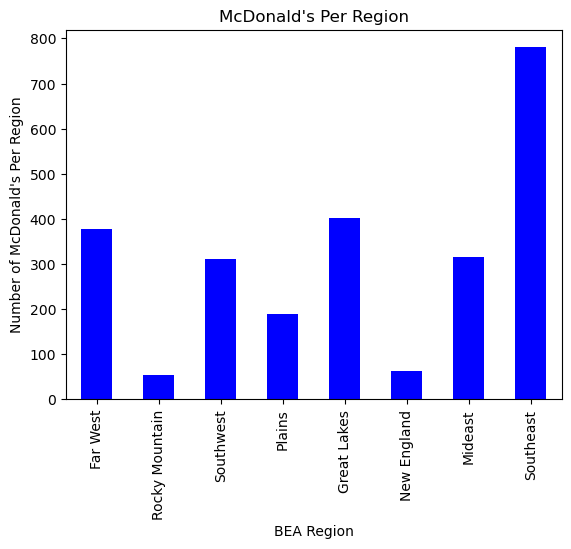

In [8]:
countPerRegion = []
for i in boxDataList:
    countPerRegion.append(sum(i))

McDPerRegion = pd.Series(
    countPerRegion,
    index=regionNames
)

McDGraph = McDPerRegion.plot(title="McDonald's Per Region",kind="bar",color="blue");
McDGraph.set_ylabel("Number of McDonald's Per Region");
McDGraph.set_xlabel("BEA Region");
McDGraph.set_xticklabels(regionNames);

Continuing with McDonald's, the above graph tells us how many McDonald's locations are in each Region. From it we can see that the region with the most McDonald's is the Southeast by a large margin, standing at around 800 individual McDonald's. The next two regions with the most locations, the Great Lakes Region and Far West, only have about half that ammount, hovering around 400 locations each. Finally, the regions with the smallest number of McDonald's are the Rocky Mountain Region and the New England Region.

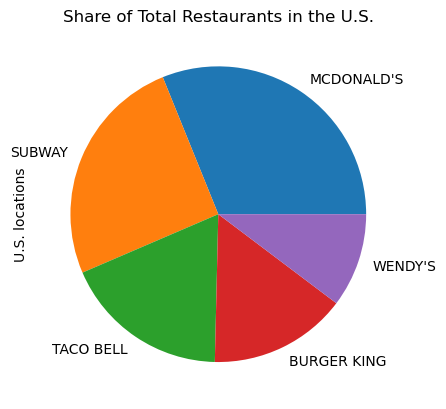

In [21]:
chainCount = fastFoodData[["name","city"]]

chainCount = chainCount.groupby("name").count().sort_values(by=["city"],ascending=False)
chainCount = chainCount.rename(columns={"city":"U.S. locations"})

chainCount.head(5).plot(title="Share of Total Restaurants in the U.S.",kind="pie",y="U.S. locations",legend=False);

In order to properly account for differences in preferences across different areas, it is important to have an idea of the share of fast-food restaurants in the U.S. that fall under each of the largest brands. From the graph above, we can see that although McDonald's is the dominant chain among the top 5, Subway is a close second. The combined share of the two chains is larger than the share of the next three combined. Of the 5 top chains, it is interesting to note that Wendy's is the smallest.

In [16]:
#Get the share of restaurants for a chain
chainCount = fastFoodData[["name","city"]]
chainCount = chainCount.groupby("name").count().sort_values(by=["city"],ascending=False)
chainCount = chainCount.rename(columns={"city":"U.S. locations"})

chainCount["share of total"] = chainCount["U.S. locations"]
numRestaurants = len(fastFoodData)

def getShare(num):
    return (num/numRestaurants)*100

chainCount["share of total"] = chainCount["share of total"].apply(getShare)

#Get similar data for New England
NEData = fastFoodData.groupby("BEA Region").get_group("New England")
numRestaurants = len(NEData)

NEChainCount = NEData[["name","city"]]
NEChainCount = NEChainCount.groupby("name").count().sort_values(by=["city"],ascending=False)
NEChainCount = NEChainCount.rename(columns={"city":"New England locations"})
NEChainCount["share of total for N.E."] = NEChainCount["New England locations"]
NEChainCount["share of total for N.E."] = NEChainCount["share of total for N.E."].apply(getShare)

NEvUSGraphData = pd.merge(NEChainCount["share of total for N.E."],chainCount["share of total"],on="name",how="left")
NEvUSGraphData = NEvUSGraphData.head(5)

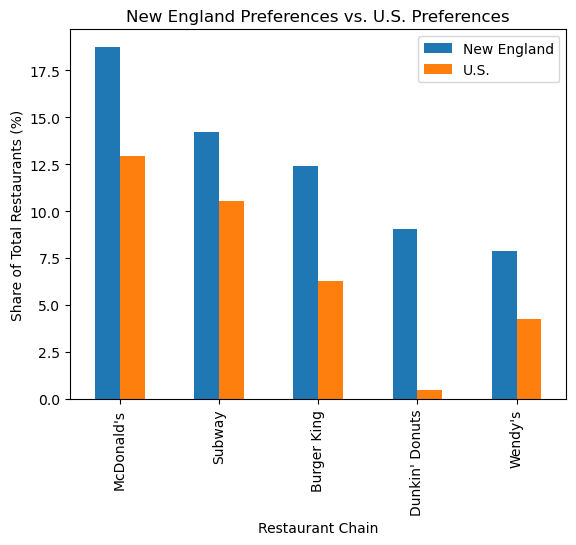

In [17]:
NEvUSGraphData = NEvUSGraphData.rename(columns={"share of total" : "U.S.", "share of total for N.E." : "New England"})

NEUSGraph = NEvUSGraphData.plot(title="New England Preferences vs. U.S. Preferences",kind="bar", xlabel="Restaurant Chain",ylabel="Share of Total Restaurants (%)");
NEUSGraph.set_xticklabels(["McDonald's","Subway","Burger King","Dunkin' Donuts", "Wendy's"]);

The graph above compares the share of total restaurant locations for the top 5 chains in New England to the share those restaurants hold in the U.S. as a whole. The most interesting takeaway is that 4 of the top 5 restaurants in the U.S. have a much higher share of restaurants in New England compared to the rest of the country. Even more interesting is the fact that Subway has been replaced by Dunkin' Donuts, immplying a regional preference for Donuts in the New England Region.

## Conclusion

We ultimately found that the different areas of the U.S. were very similar when it came to their top fast food choices. McDonald's, Subway, and Burger King being among the most popular chains within the country. McDonald's was the most popular, and different regions had vastly different concentrations of McDonald's. The restaurant was disproportionately popular in the Southeast, which had the highest number of McDonald's and was among the regions with the most McDonald's per city.

Despite this, different regions did display different preferences. The afformentioned findings on McDonald's is an example of this, but more notably, New England displayed a disproportionately large preference for donuts, with Dunkin' Donuts being one of their most numerous chains.